In [3]:
using ITensors, ITensorMPS
using LinearAlgebra
using SparseArrays
using Plots

In [2]:
include("src/main.jl")
include("src/observables.jl")
include("src/states.jl")
include("src/singled_measurements.jl")

forced_singled_measure_with_val (generic function with 2 methods)

In [3]:
function MPS_update_data(ρ::MPS, observables::Vector{Symbol}, data::Dict{Symbol,Vector{ComplexF64}}, t::Int; ref=false)
    if :Ic in observables
        data[:Ic][t] = Ic2(ρ)
    end
    if :SR in observables
        data[:SR][t] = SR(ρ)
    end
    if :pure_SR in observables
        data[:pure_SR][t] = pure_SR(ρ)
    end
    if :κEA in observables
        data[:κEA][t] = κEA(ρ; ref=ref)
    end
    if :pure_κEA in observables
        data[:pure_κEA][t] = pure_κEA(ρ; ref=ref)
    end
    if :κ2 in observables
        data[:κ2][t] = κ2(ρ; ref=ref)
    end
    if :maxlinkdim in observables
        data[:maxlinkdim][t] = maxlinkdim(ρ)
    end
    return data
end

MPS_update_data (generic function with 1 method)

In [4]:
# function circuit(L::Int, T::Int, Δ::Float64, δ::Float64, q::Float64, θ::Float64; observables=Symbol[], cutoff=1E-8, maxdim=200)
#     ρ, sites = ghz(L; ref=true)

#     data = Dict([s => zeros(ComplexF64, 2T+2) for s in observables])
#     data = MPS_update_data(ρ, observables, data, 1; ref=true)
#     data = MPS_update_data(ρ, observables, data, 2; ref=true)

#     λzz = δ*sqrt( (1-Δ)/2 )
#     λx = δ*sqrt( (1+Δ)/2 )

#     Xn = decoherence_layer(sites, PauliX, q, 1:L, L)
#     ZZn = decoherence_layer(sites, kron(PauliZ, PauliZ), q, 1:L-1, L)

#     Xu = coherent_layer(sites, PauliX, θ, 1:L, L)
#     ZZu = coherent_layer(sites, kron(PauliZ, PauliZ), θ, 1:L-1, L)

#     bell_state = bell(sites)


#     for t in 1:T
#         ρ, _, _ = doubled_measure(ρ, PauliX, λx, 1:L; ref=true)
#         ρ /= inner(bell_state, ρ)
#         truncate!(ρ; cutoff=cutoff, maxdim=maxdim)

#         ρ = apply(Xn, ρ)
#         ρ /= inner(bell_state, ρ)
#         truncate!(ρ; cutoff=cutoff, maxdim=maxdim)

#         ρ = apply(Xu, ρ)
#         ρ /= inner(bell_state, ρ)
#         truncate!(ρ; cutoff=cutoff, maxdim=maxdim)

#         data = MPS_update_data(ρ, observables, data, 2t+1; ref=true)

#         ρ, _, _ = doubled_measure(ρ, kron(PauliZ,PauliZ), λzz, 1:L-1; ref=true)
#         ρ /= inner(bell_state, ρ)
#         truncate!(ρ; cutoff=cutoff, maxdim=maxdim)

#         ρ = apply(ZZn, ρ)
#         ρ /= inner(bell_state, ρ)
#         truncate!(ρ; cutoff=cutoff, maxdim=maxdim)

#         ρ = apply(ZZu, ρ)
#         ρ /= inner(bell_state, ρ)
#         truncate!(ρ; cutoff=cutoff, maxdim=maxdim)

#         data = MPS_update_data(ρ, observables, data, 2t+2; ref=true)
#     end

#     return ρ, data
# end

In [5]:
function pure_circuit(L::Int, T::Int, Δ::Float64, δ::Float64, θ::Float64; observables=Symbol[], cutoff=1E-8, maxdim=200)
    ψ, sites = pure_ghz(L; ref=true)

    data = Dict([s => zeros(ComplexF64, 2T+2) for s in observables])
    data = MPS_update_data(ψ, observables, data, 1; ref=true)
    data = MPS_update_data(ψ, observables, data, 2; ref=true)

    λzz = δ*sqrt( (1-Δ)/2 )
    λx = δ*sqrt( (1+Δ)/2 )

    Xu = singled_coherent_layer(sites, PauliX, θ, 1:L, L)
    ZZu = singled_coherent_layer(sites, kron(PauliZ, PauliZ), θ, 1:L-1, L)

    for t in 1:T
        ψ, _, _ = singled_measure(ψ, PauliX, λx, 1:L; ref=true)
        ψ /= norm(ψ)
        truncate!(ψ; cutoff=cutoff, maxdim=maxdim)

        ψ = apply(Xu, ψ)
        ψ /= norm(ψ)
        truncate!(ψ; cutoff=cutoff, maxdim=maxdim)

        data = MPS_update_data(ψ, observables, data, 2t+1; ref=true)

        ψ, _, _ = singled_measure(ψ, kron(PauliZ,PauliZ), λzz, 1:L-1; ref=true)
        ψ /= norm(ψ)
        truncate!(ψ; cutoff=cutoff, maxdim=maxdim)

        ψ = apply(ZZu, ψ)
        ψ /= norm(ψ)
        truncate!(ψ; cutoff=cutoff, maxdim=maxdim)

        data = MPS_update_data(ψ, observables, data, 2t+2; ref=true)
    end

    return ψ, data
end

pure_circuit (generic function with 1 method)

In [6]:
function sample(L::Int, T::Int, Δ::Float64, δ::Float64, θ::Float64, samples::Int; observables=Symbol[], cutoff=1E-8, maxdim=200)
    mean_data = Dict([s => zeros(ComplexF64, 2T+2) for s in observables])
    for _ in 1:samples
        _, sample_data = pure_circuit(L, 2L, Δ, δ, θ; observables=observables)
        for observable in observables
            mean_data[observable] += sample_data[observable]
        end
    end
    for observable in observables
        mean_data[observable] /= samples
    end
    return mean_data
end

sample (generic function with 1 method)

In [ ]:
# data = Dict{Tuple{Int, Int, Float64, Float64, Float64},Tuple{Int,Dict}}()

Dict{Tuple{Int64, Int64, Float64, Float64, Float64}, Tuple{Int64, Dict}}()

In [ ]:
# observables = Symbol[:pure_κEA, :pure_SR, :maxlinkdim]
# samples = 150
# δ = 0.7
# # θ = 0.2

# for θ in [0.0,0.1,0.2,0.5]
#     for Δ in -1.0:0.25:1.0
#         for L in 4:4:12
#             T = 2L
#             data[(L,T,Δ,δ,θ)] = (samples, sample(L, T, Δ, δ, θ, samples; observables=observables))
#         end
#     end
# end

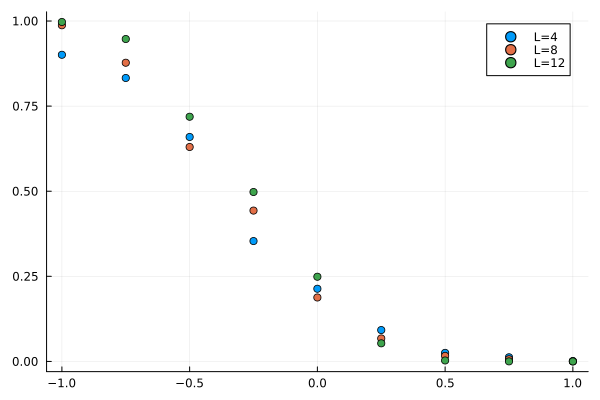

In [28]:

δ = 0.7
θ = 0.2
observable  = :pure_SR

plt = plot()
for L in 4:4:12
    xs = -1.0:0.25:1.0
    ys = [real.(data[(L,2L,Δ,δ,θ)][2][observable][end-1]) for Δ in xs]
    plot!(plt, xs, ys, seriestype=:scatter, label="L=$L")
end
plt

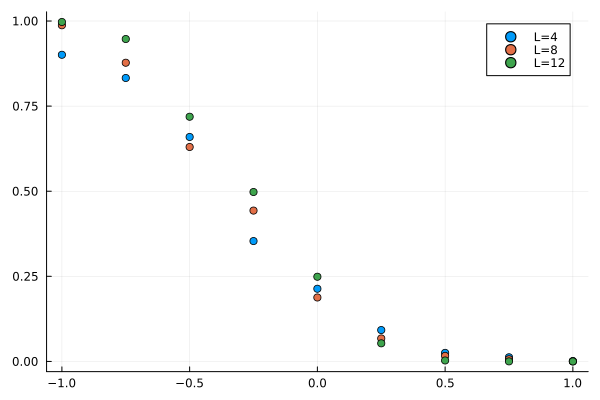

In [21]:

δ = 0.7
θ = 0.2
observable  = :pure_SR

plt = plot()
for L in 4:4:12
    xs = -1.0:0.25:1.0
    ys = [real.(data[(L,2L,Δ,δ,θ)][2][observable][end-1]) for Δ in xs]
    plot!(plt, xs, ys, seriestype=:scatter, label="L=$L")
end
plt

In [ ]:
L = 8
T = 2L
Δ = 0.0
δ = 0.7
θ = 0.1

# samples = 100
observables = Symbol[:pure_κEA, :pure_SR, :maxlinkdim]
data = sample(L, T, Δ, δ, θ, 100; observables=observables)


In [28]:
data[:pure_SR]

34-element Vector{ComplexF64}:
                 1.0 + 0.0im
                 1.0 + 0.0im
  0.9815027660824017 + 0.0im
   0.908637001325767 + 0.0im
  0.8846744550982141 + 0.0im
  0.9548874848520228 + 0.0im
  0.8740851572487731 + 0.0im
  0.9092555819332946 + 0.0im
  0.9747725308995869 + 0.0im
  0.9988679731691514 + 0.0im
                     ⋮
  0.4574788944047322 + 0.0im
 0.44123673095898264 + 0.0im
 0.41713765137955866 + 0.0im
  0.3426441983483129 + 0.0im
   0.252270800420597 + 0.0im
  0.3517528298690492 + 0.0im
  0.2996631592147914 + 0.0im
 0.24753973555002162 + 0.0im
 0.25020676089439825 + 0.0im

In [ ]:
# do single pure state for coherent error to show gap when q = 0 more efficiently

In [4]:
using JLD2
# jldsave("25_07_16_unitary_data.jld2"; data)

In [5]:
data = jldopen("25_07_16_unitary_data.jld2")["data"]

Dict{Tuple{Int64, Int64, Float64, Float64, Float64}, Tuple{Int64, Dict}} with 162 entries:
  (12, 24, 0.0, 0.7, 0.1)   => (150, Dict{Symbol, Vector{ComplexF64}}(:maxlinkd…
  (8, 16, 0.5, 0.7, 0.2)    => (150, Dict{Symbol, Vector{ComplexF64}}(:maxlinkd…
  (8, 16, -1.0, 0.7, 0.0)   => (150, Dict{Symbol, Vector{ComplexF64}}(:maxlinkd…
  (4, 8, -0.25, 0.7, 0.0)   => (150, Dict{Symbol, Vector{ComplexF64}}(:maxlinkd…
  (12, 24, -0.25, 0.7, 0.4) => (1, Dict{Symbol, Vector{ComplexF64}}(:maxlinkdim…
  (4, 8, -0.5, 0.7, 0.5)    => (150, Dict{Symbol, Vector{ComplexF64}}(:maxlinkd…
  (12, 24, 1.0, 0.7, 0.3)   => (1, Dict{Symbol, Vector{ComplexF64}}(:maxlinkdim…
  (4, 8, -1.0, 0.7, 0.1)    => (150, Dict{Symbol, Vector{ComplexF64}}(:maxlinkd…
  (4, 8, 0.75, 0.7, 0.3)    => (1, Dict{Symbol, Vector{ComplexF64}}(:maxlinkdim…
  (4, 8, 0.5, 0.7, 0.4)     => (1, Dict{Symbol, Vector{ComplexF64}}(:maxlinkdim…
  (12, 24, -0.75, 0.7, 0.0) => (150, Dict{Symbol, Vector{ComplexF64}}(:maxlinkd…
  (8, 16, 0.75, 0.